# Lesson - Feature Selection 1

## Imports and Options

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# Preprocessing tools
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Setting options
n=800
pd.set_option('display.max_columns',n)
pd.set_option("display.max_info_rows", n)
pd.set_option('display.max_info_columns',n)
from sklearn import set_config
set_config(transform_output='pandas')

## Custom Functions

In [5]:
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
def classification_metrics(y_true, y_pred, label="",
                           output_dict=False, figsize=(8,4),
                           normalize='true', cmap='Blues',
                           colorbar=False):
  # Get the classification report
  report = classification_report(y_true, y_pred)
  ## Print header and report
  header = "-"*70
  print(header, f" Classification Metrics: {label}", header, sep='\n')
  print(report)
  ## CONFUSION MATRICES SUBPLOTS
  fig, axes = plt.subplots(ncols=2, figsize=figsize)
  # create a confusion matrix  of raw counts
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=None, cmap='gist_gray', colorbar=colorbar,
                ax = axes[0],);
  axes[0].set_title("Raw Counts")
  # create a confusion matrix with the test data
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=normalize, cmap=cmap, colorbar=colorbar,
                ax = axes[1]);
  axes[1].set_title("Normalized Confusion Matrix")
  # Adjust layout and show figure
  fig.tight_layout()
  plt.show()
  # Return dictionary of classification_report
  if output_dict==True:
    report_dict = classification_report(y_true, y_pred, output_dict=True)
    return report_dict
    
    
    
def evaluate_classification(model, X_train, y_train, X_test, y_test,
                         figsize=(6,4), normalize='true', output_dict = False,
                            cmap_train='Blues', cmap_test="Reds",colorbar=False):
  # Get predictions for training data
  y_train_pred = model.predict(X_train)
  # Call the helper function to obtain regression metrics for training data
  results_train = classification_metrics(y_train, y_train_pred, #verbose = verbose,
                                     output_dict=True, figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_train,
                                     label='Training Data')
  print()
  # Get predictions for test data
  y_test_pred = model.predict(X_test)
  # Call the helper function to obtain regression metrics for test data
  results_test = classification_metrics(y_test, y_test_pred, #verbose = verbose,
                                  output_dict=True,figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_test,
                                    label='Test Data' )
  if output_dict == True:
    # Store results in a dataframe if ouput_frame is True
    results_dict = {'train':results_train,
                    'test': results_test}
    return results_dict

## Load Data

In [6]:
# Load Data
df = pd.read_csv('Data/pd_speech_features.csv')
df.head()

,id,gender,PPE,DFA,RPDE,numPulses,numPeriodsPulses,meanPeriodPulses,stdDevPeriodPulses,locPctJitter,locAbsJitter,rapJitter,ppq5Jitter,ddpJitter,locShimmer,locDbShimmer,apq3Shimmer,apq5Shimmer,apq11Shimmer,ddaShimmer,meanAutoCorrHarmonicity,meanNoiseToHarmHarmonicity,meanHarmToNoiseHarmonicity,minIntensity,maxIntensity,meanIntensity,f1,f2,f3,f4,b1,b2,b3,b4,GQ_prc5_95,GQ_std_cycle_open,GQ_std_cycle_closed,GNE_mean,GNE_std,GNE_SNR_TKEO,GNE_SNR_SEO,GNE_NSR_TKEO,GNE_NSR_SEO,VFER_mean,VFER_std,VFER_entropy,VFER_SNR_TKEO,VFER_SNR_SEO,VFER_NSR_TKEO,VFER_NSR_SEO,IMF_SNR_SEO,IMF_SNR_TKEO,IMF_SNR_entropy,IMF_NSR_SEO,IMF_NSR_TKEO,IMF_NSR_entropy,mean_Log_energy,mean_MFCC_0th_coef,mean_MFCC_1st_coef,mean_MFCC_2nd_coef,mean_MFCC_3rd_coef,mean_MFCC_4th_coef,mean_MFCC_5th_coef,mean_MFCC_6th_coef,mean_MFCC_7th_coef,mean_MFCC_8th_coef,mean_MFCC_9th_coef,mean_MFCC_10th_coef,mean_MFCC_11th_coef,mean_MFCC_12th_coef,mean_delta_log_energy,mean_0th_delta,mean_1st_delta,mean_2nd_delta,mean_3rd_delta,mean_4th_delta,mean_5th_delta,mean_6th_delta,mean_7th_delta,mean_8th_delta,mean_9th_delta,mean_10th_delta,mean_11th_delta,mean_12th_delta,mean_delta_delta_log_energy,mean_delta_delta_0th,mean_1st_delta_delta,mean_2nd_delta_delta,mean_3rd_delta_delta,mean_4th_delta_delta,mean_5th_delta_delta,mean_6th_delta_delta,mean_7th_delta_delta,mean_8th_delta_delta,mean_9th_delta_delta,mean_10th_delta_delta,mean_11th_delta_delta,mean_12th_delta_delta,std_Log_energy,std_MFCC_0th_coef,std_MFCC_1st_coef,std_MFCC_2nd_coef,std_MFCC_3rd_coef,std_MFCC_4th_coef,std_MFCC_5th_coef,std_MFCC_6th_coef,std_MFCC_7th_coef,std_MFCC_8th_coef,std_MFCC_9th_coef,std_MFCC_10th_coef,std_MFCC_11th_coef,std_MFCC_12th_coef,std_delta_log_energy,std_0th_delta,std_1st_delta,std_2nd_delta,std_3rd_delta,std_4th_delta,std_5th_delta,std_6th_delta,std_7th_delta,std_8th_delta,std_9th_delta,std_10th_delta,std_11th_delta,std_12th_delta,std_delta_delta_log_energy,std_delta_delta_0th,std_1st_delta_delta,std_2nd_delta_delta,std_3rd_delta_delta,std_4th_delta_delta,std_5th_delta_delta,std_6th_delta_delta,std_7th_delta_delta,std_8th_delta_delta,std_9th_delta_delta,std_10th_delta_delta,std_11th_delta_delta,std_12th_delta_delta,Ea,Ed_1_coef,Ed_2_coef,Ed_3_coef,Ed_4_coef,Ed_5_coef,Ed_6_coef,Ed_7_coef,Ed_8_coef,Ed_9_coef,Ed_10_coef,det_entropy_shannon_1_coef,det_entropy_shannon_2_coef,det_entropy_shannon_3_coef,det_entropy_shannon_4_coef,det_entropy_shannon_5_coef,det_entropy_shannon_6_coef,det_entropy_shannon_7_coef,det_entropy_shannon_8_coef,det_entropy_shannon_9_coef,det_entropy_shannon_10_coef,det_entropy_log_1_coef,det_entropy_log_2_coef,det_entropy_log_3_coef,det_entropy_log_4_coef,det_entropy_log_5_coef,det_entropy_log_6_coef,det_entropy_log_7_coef,det_entropy_log_8_coef,det_entropy_log_9_coef,det_entropy_log_10_coef,det_TKEO_mean_1_coef,det_TKEO_mean_2_coef,det_TKEO_mean_3_coef,det_TKEO_mean_4_coef,det_TKEO_mean_5_coef,det_TKEO_mean_6_coef,det_TKEO_mean_7_coef,det_TKEO_mean_8_coef,det_TKEO_mean_9_coef,det_TKEO_mean_10_coef,det_TKEO_std_1_coef,det_TKEO_std_2_coef,det_TKEO_std_3_coef,det_TKEO_std_4_coef,det_TKEO_std_5_coef,det_TKEO_std_6_coef,det_TKEO_std_7_coef,det_TKEO_std_8_coef,det_TKEO_std_9_coef,det_TKEO_std_10_coef,app_entropy_shannon_1_coef,app_entropy_shannon_2_coef,app_entropy_shannon_3_coef,app_entropy_shannon_4_coef,app_entropy_shannon_5_coef,app_entropy_shannon_6_coef,app_entropy_shannon_7_coef,app_entropy_shannon_8_coef,app_entropy_shannon_9_coef,app_entropy_shannon_10_coef,app_entropy_log_1_coef,app_entropy_log_2_coef,app_entropy_log_3_coef,app_entropy_log_4_coef,app_entropy_log_5_coef,app_entropy_log_6_coef,app_entropy_log_7_coef,app_entropy_log_8_coef,app_entropy_log_9_coef,app_entropy_log_10_coef,app_det_TKEO_mean_1_coef,app_det_TKEO_mean_2_coef,app_det_TKEO_mean_3_coef,app_det_TKEO_mean_4_coef,app_det_TKEO_mean_5_coef,app_det_TKEO_mean_6_coef,app_det_TKEO_mean_7_coef,app_det_TKEO_mean_8_coef,app_det_TKEO_mean_9_coef,app_det_TKEO_mean_10_coef,app_TKEO_std_1_coef,app_TKEO_std_2_coef,app_TKEO_

In [7]:
# view columns dtypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 756 entries, 0 to 755
Data columns (total 755 columns):
 #    Column                          Non-Null Count  Dtype  
---   ------                          --------------  -----  
 0    id                              756 non-null    int64  
 1    gender                          756 non-null    int64  
 2    PPE                             756 non-null    float64
 3    DFA                             756 non-null    float64
 4    RPDE                            756 non-null    float64
 5    numPulses                       756 non-null    int64  
 6    numPeriodsPulses                756 non-null    int64  
 7    meanPeriodPulses                756 non-null    float64
 8    stdDevPeriodPulses              756 non-null    float64
 9    locPctJitter                    756 non-null    float64
 10   locAbsJitter                    756 non-null    float64
 11   rapJitter                       756 non-null    float64
 12   ppq5Jitter          

## Preprocessing

In [10]:
# check for null values
df.isna().sum().sum()

0

In [12]:
# check unique datatypes
df.dtypes.unique()

array([dtype('int64'), dtype('float64')], dtype=object)

### Train Test Split

In [13]:
# define X and y
X = df.drop(columns=['class','id'])
y = df['class'].copy()

In [16]:
# tts
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=321)

## Scale

In [18]:
# instantiate scaler
scaler = StandardScaler()

In [19]:
# fit scaler on X_train
scaler.fit(X_train)

StandardScaler()

In [20]:
# transform X_train
X_train_scaled = scaler.transform(X_train)

In [21]:
# transform X_test
X_test_scaled = scaler.transform(X_test)

### Class Balance

In [23]:
# check balance of y with value_counts (use 1 as arg to get percentage instead of raw counts)
y.value_counts(1)

1    0.746032
0    0.253968
Name: class, dtype: float64

### address imbalancing with SMOTE

In [24]:
# import SMOTE
from imblearn.over_sampling import SMOTE

In [25]:
# instantiate SMOTE
smote = SMOTE(random_state=42)

In [26]:
# fit and resample SMOTE on X_train_scaled, y_train
X_train_sm, y_train_sm = smote.fit_resample(X_train_scaled, y_train)

In [35]:
# check class balance of new variable y_train_sm
y_train_sm.value_counts(1)

1    0.5
0    0.5
Name: class, dtype: float64

## Modeling

### Run model on scaled and resampled data to compare prior to Feature Selection

In [36]:
# instantiate default random forest with 42 as random state for reproductibility
rf_clf = RandomForestClassifier(random_state=42)

In [37]:
# fit rf_clf on training data
rf_clf.fit(X_train_sm, y_train_sm)

RandomForestClassifier(random_state=42)

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       427
           1       1.00      1.00      1.00       427

    accuracy                           1.00       854
   macro avg       1.00      1.00      1.00       854
weighted avg       1.00      1.00      1.00       854



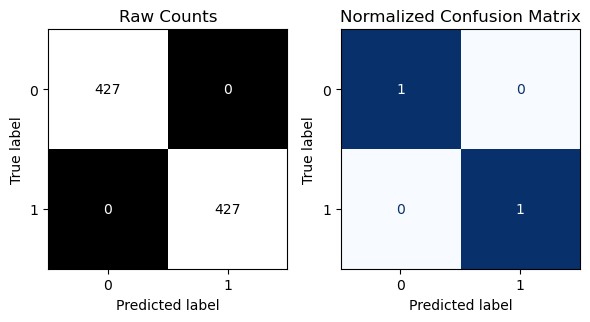


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.73      0.63      0.68        52
           1       0.87      0.91      0.89       137

    accuracy                           0.84       189
   macro avg       0.80      0.77      0.79       189
weighted avg       0.83      0.84      0.83       189



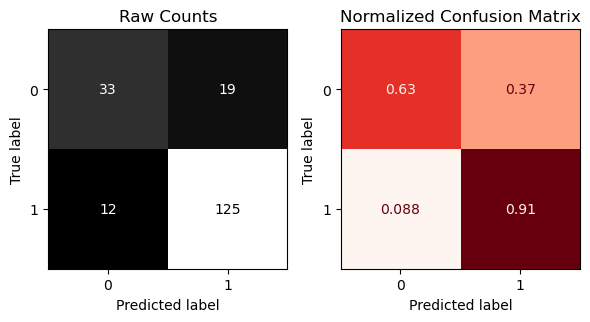

In [38]:
# evaluate with custom function
evaluate_classification(rf_clf,X_train_sm, y_train_sm, X_test_scaled, y_test)

## Filter Methods

### Correlation

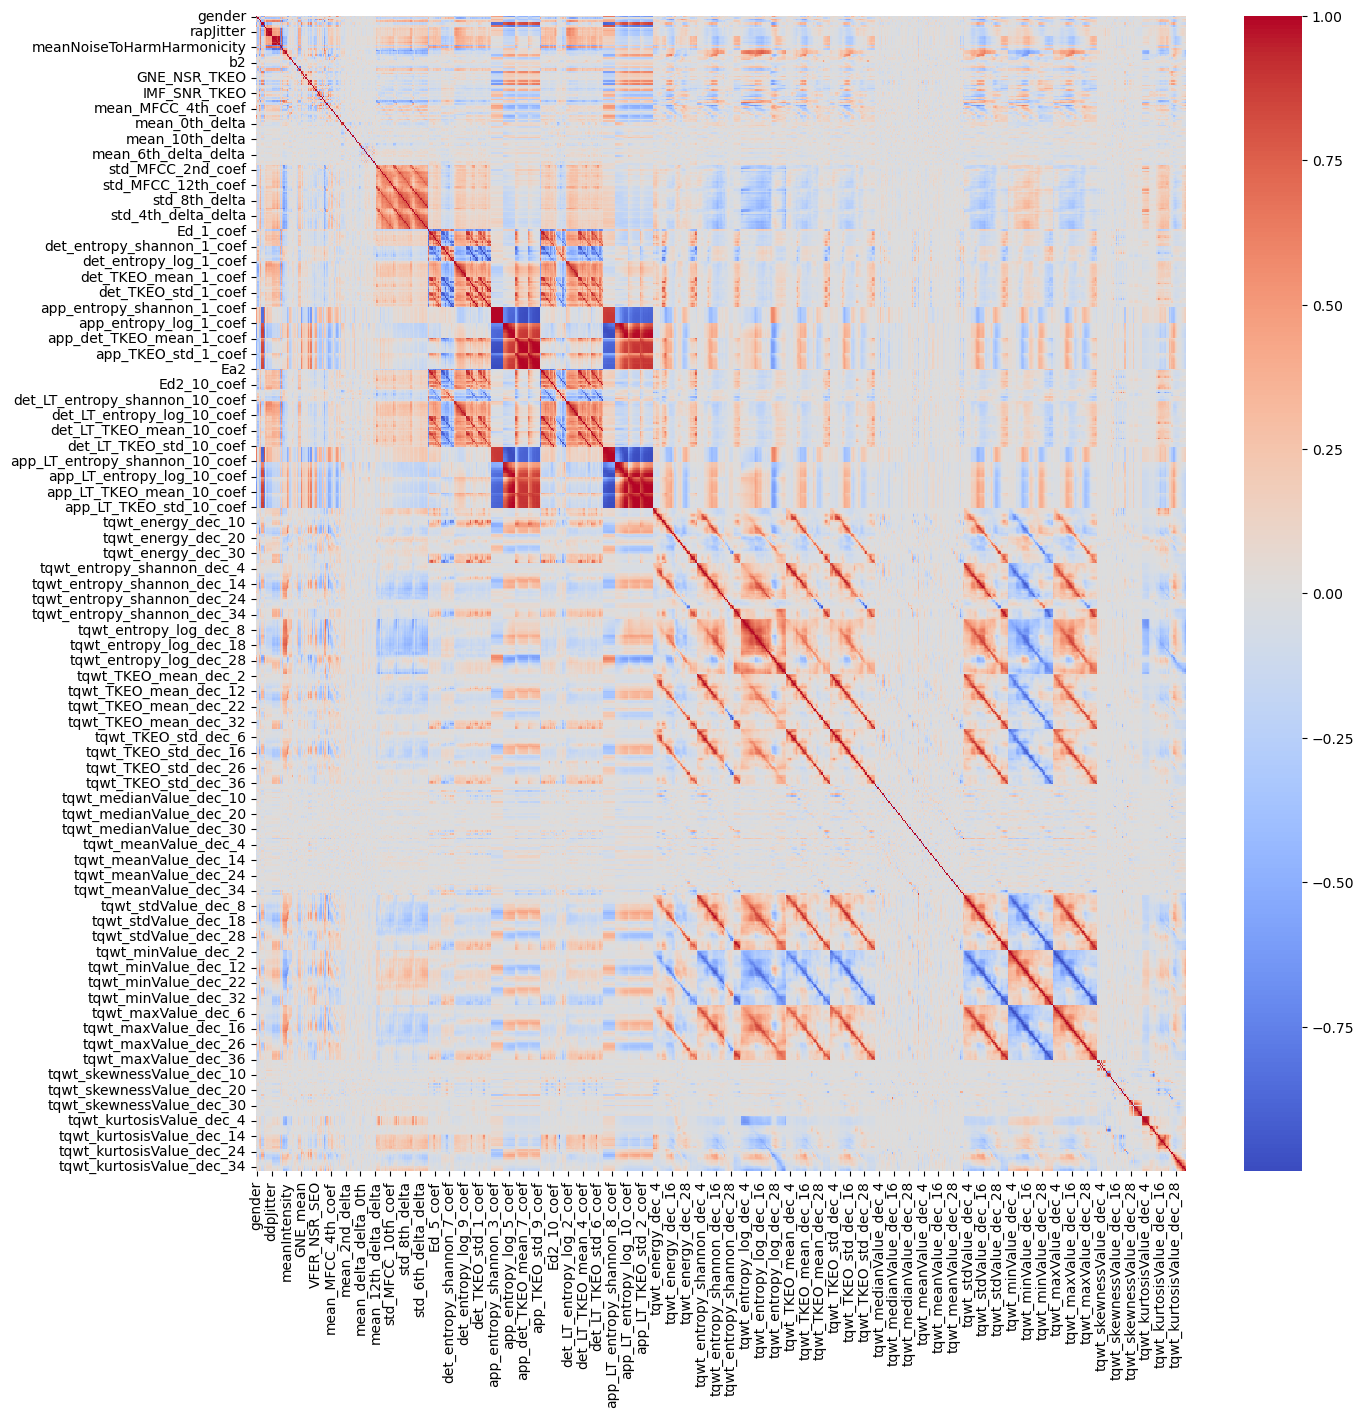

In [41]:
# create heatmap using all features
corr = X_train_sm.corr()
plt.figure(figsize=(15,15))
sns.heatmap(corr,cmap='coolwarm');

In [43]:
# import package to filter dataset to only include features that are non-collinear
from collinearity import SelectNonCollinear

In [44]:
# import appropriate scoring metric for supervised learning task (reg = f_regression, clf = f_classif)
from sklearn.feature_selection import f_classif

In [45]:
# instantiate selector with .75 correlation_threshold and include scoring = metric
selector = SelectNonCollinear(correlation_threshold=.75, scoring = f_classif)

In [47]:
# fit on training data - must use .values because X and y need to be arrays for selector
selector.fit(X_train_sm.values,y_train_sm.values)

In [48]:
# use .get_support() to obtain list of True or False for each feature
# True = correlation < .75
# False = correlation > .75
non_collinear = selector.get_support()

In [50]:
# preview non_collinear list
non_collinear[:10]

[True, True, True, True, False, True, False, True, True, False]

In [55]:
# count how many values are True/below .75 threshold ( we will keep thease features )
non_collinear.count(True)

299

In [56]:
# count how many values are False/above .75 threshold ( we will drop these features)
non_collinear.count(False)

454

In [57]:
# make a series of all features using selector again and whether or not they will be dropped with X_train_sm columns as index)
non_collinear_series = pd.Series(selector.get_support(), index=X_train_sm.columns)

In [58]:
# view series
non_collinear_series

gender                        True
PPE                           True
DFA                           True
RPDE                          True
numPulses                    False
                             ...  
tqwt_kurtosisValue_dec_32    False
tqwt_kurtosisValue_dec_33     True
tqwt_kurtosisValue_dec_34    False
tqwt_kurtosisValue_dec_35    False
tqwt_kurtosisValue_dec_36     True
Length: 753, dtype: bool

In [59]:
# filter training data to only include True values (non-collinear)
training_data_to_keep = X_train_sm.values[:, non_collinear]

In [64]:
# filter column names to only those that are non-collinear
columns = np.array(X_train_sm.columns)[non_collinear]

In [69]:
# make training data into df
X_train_no_corr = pd.DataFrame(training_data_to_keep, columns = columns)

In [68]:
# filter testing data
test_data_to_keep = X_test_scaled.values[:,non_collinear]

In [71]:
# make testing data into df
X_test_no_corr = pd.DataFrame(test_data_to_keep, columns = columns)

In [77]:
# make df
no_corr = [X_train_no_corr, X_test_no_corr]
no_corr_df = pd.concat
no_corr_df.head()

TypeError: 'function' object is not subscriptable

In [75]:
# create new heatmap with non_collinear features
corr = no_corr_df.corr()
plt.figure(figsize=(15,15))
sns.heatmap(corr,cmap='coolwarm');

NameError: name 'no_corr_df' is not defined